In [1]:
# Dependencies
import os
import pandas as pd
from citipy import citipy
import numpy as np
from pprint import pprint
from config import api_key
import matplotlib.pyplot as plt
import json
import requests

## Create a list of cities

In [2]:
# Create a random list of latitudes and longitudes
# np.random.uniform makes sure that all the numbers in the range get equal chance of getting picked

latitudes = np.random.uniform(-90, 90, size = 2000) # 500 random numbers from -90 to 90 deg latitude
longitudes = np.random.uniform(-180, 180, size = 2000) # 500 random numbers from -180 to 180 deg longitude

coordinates = list(zip(latitudes, longitudes))

In [3]:
# Nearby cities per latitude-longitude pair
cities = []

for coord in coordinates:
    lat, lon = coord
    cities.append(citipy.nearest_city(lat, lon))

In [48]:
# Set of cities
city_names = []
country = []

for city in cities:
    city_names.append(city.city_name) # loop through the city coordinates to get the city names
    country.append(city.country_code) # loop through the city coordinates to get the city names
    
city_dict ={
    "city": city_names,
    "country": country,
    "latitude": latitudes,
    "longitude": longitudes
           }    

city_df = pd.DataFrame(city_dict)
city_df = city_df.drop_duplicates(["city","country"]) # drop city-country duplicates
city_df = city_df.dropna() # drop rows with missing values

In [5]:
# Add new columns
city_df["Temperature (F)"] = ""
city_df["Humidity (%)"] = ""
city_df["Cloudiness (%)"] = ""
city_df["Wind Speed (mph)"] = ""
city_df.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,sopelana,es,43.731374,-3.000585,,,,
1,ushuaia,ar,-68.986720,-53.435644,,,,
2,banda aceh,id,2.242317,90.315992,,,,
3,grand gaube,mu,-15.505464,64.641149,,,,
4,tasiilaq,gl,76.497003,-34.247752,,,,


In [6]:
# Get JSON file containing city ID
filepath = os.path.join("Resources","city.list.json")
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [7]:
# Get the city name, country code, and city ID 
# City IDs are more reliable because they are unique identifiers; there could be cities with the same name but in different countries

ct_name = []
co_name = []
ct_ID = []

for i in json_data:
    ct_name.append(i["name"]) # city name from JSON file
    co_name.append(i["country"]) # country name from JSON file
    ct_ID.append(i["id"]) # city ID from JSON file

In [8]:
# Put the JSON-sourced data into a dataframe
json_dict = {
    "city": ct_name,
    "country": co_name,
    "city ID": ct_ID}

json_df = pd.DataFrame(json_dict)
json_df["city"] = json_df["city"].str.lower() # make the letters lowercase
json_df["country"] = json_df["country"].str.lower() # make the letters lowercase
json_df.head()

,city,country,city ID
0,hurzuf,ua,707860
1,novinki,ru,519188
2,gorkhā,np,1283378
3,state of haryāna,in,1270260
4,holubynka,ua,708546


In [18]:
# Merge json_df and city_df
city_df2 = pd.merge(city_df,json_df, on = ["city", "country"])
city_df2 = city_df2.drop_duplicates(["city", "country"])
print(f"There are {len(city_df2)} cities in this dataframe.")
city_df2.head()

There are 654 cities in this dataframe.


,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,sopelana,es,43.731374,-3.000585,,,,,6362425
2,ushuaia,ar,-68.986720,-53.435644,,,,,3833367
3,banda aceh,id,2.242317,90.315992,,,,,1215501
5,grand gaube,mu,-15.505464,64.641149,,,,,934479
6,tasiilaq,gl,76.497003,-34.247752,,,,,3424607


## Get the weather for each city through the OpenWeatherData API

In [40]:
# Formulate the query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Loop through the rows to get the different cities and countries
for index, row in city_df2.iterrows():
    x = row["city"]
    y = row["country"]
    
    # Create a variable for iteration through the dataframe
    city_ID = row["city ID"]
    
    # Create a query URL
    query_url = f"{url}&appid={api_key}&id={city_ID}&units={units}"
    
    # Create a request and JSON-ify
    print(f"Retrieving information for Index {index}: {x},{y} (ID: {city_ID}).")
    response = requests.get(query_url)
    response_json = response.json()
    
    # Extract response
    try:
        print(f"{x},{y} (ID: {city_ID}) has {response_json['clouds']['all']}% cloudiness.")
        
        city_df2.loc[index, "Cloudiness (%)"] = response_json["clouds"]["all"]
        city_df2.loc[index, "Humidity (%)"] = response_json["main"]["humidity"]
        city_df2.loc[index, "Wind Speed (mph)"] = response_json["wind"]["speed"]
        city_df2.loc[index, "Temperature (F)"] = response_json["main"]["temp"]
    
    except (KeyError, IndexError):
        print("The city is not on the list. It will rain meatballs!")
    
    print("----------")

Retrieving information for Index 0: 6362425.
sopelana,es has 75% cloudiness.
----------
Retrieving information for Index 2: 3833367.
ushuaia,ar has 75% cloudiness.
----------
Retrieving information for Index 3: 1215501.
banda aceh,id has 88% cloudiness.
----------
Retrieving information for Index 5: 934479.
grand gaube,mu has 20% cloudiness.
----------
Retrieving information for Index 6: 3424607.
tasiilaq,gl has 64% cloudiness.
----------
Retrieving information for Index 7: 4182260.
bethel,us has 1% cloudiness.
----------
Retrieving information for Index 18: 7839477.
busselton,au has 56% cloudiness.
----------
Retrieving information for Index 20: 1649150.
bengkulu,id has 92% cloudiness.
----------
Retrieving information for Index 21: 4030556.
rikitea,pf has 92% cloudiness.
----------
Retrieving information for Index 22: 1650600.
balaipungut,id has 40% cloudiness.
----------
Retrieving information for Index 23: 212730.
kisangani,cd has 36% cloudiness.
----------
Retrieving information f

miacatlan,mx has 40% cloudiness.
----------
Retrieving information for Index 144: 2022232.
khrebtovaya,ru has 8% cloudiness.
----------
Retrieving information for Index 145: 1895695.
kushima,jp has 75% cloudiness.
----------
Retrieving information for Index 146: 3083955.
swinoujscie,pl has 0% cloudiness.
----------
Retrieving information for Index 147: 3401138.
custodia,br has 0% cloudiness.
----------
Retrieving information for Index 148: 3451138.
rio grande,br has 0% cloudiness.
----------
Retrieving information for Index 149: 1490256.
talnakh,ru has 80% cloudiness.
----------
Retrieving information for Index 150: 3573062.
saint george,bm has 90% cloudiness.
----------
Retrieving information for Index 152: 3443061.
chuy,uy has 0% cloudiness.
----------
Retrieving information for Index 153: 1015776.
bredasdorp,za has 0% cloudiness.
----------
Retrieving information for Index 154: 1490796.
strezhevoy,ru has 75% cloudiness.
----------
Retrieving information for Index 155: 1487332.
verkh

kodiak,us has 1% cloudiness.
----------
Retrieving information for Index 265: 3945985.
camana,pe has 92% cloudiness.
----------
Retrieving information for Index 266: 2071860.
esperance,au has 100% cloudiness.
----------
Retrieving information for Index 267: 2303287.
bawku,gh has 0% cloudiness.
----------
Retrieving information for Index 268: 5557293.
sitka,us has 90% cloudiness.
----------
Retrieving information for Index 269: 2015306.
tiksi,ru has 32% cloudiness.
----------
Retrieving information for Index 270: 2025630.
chara,ru has 0% cloudiness.
----------
Retrieving information for Index 271: 556268.
ostrovnoy,ru has 68% cloudiness.
----------
Retrieving information for Index 272: 1262065.
nalhati,in has 8% cloudiness.
----------
Retrieving information for Index 273: 1785036.
zhangye,cn has 20% cloudiness.
----------
Retrieving information for Index 274: 6170031.
tuktoyaktuk,ca has 88% cloudiness.
----------
Retrieving information for Index 275: 3412093.
vestmannaeyjar,is has 75% c

ust-barguzin,ru has 0% cloudiness.
----------
Retrieving information for Index 376: 1852109.
shingu,jp has 75% cloudiness.
----------
Retrieving information for Index 378: 5861897.
fairbanks,us has 90% cloudiness.
----------
Retrieving information for Index 379: 6355222.
yulara,au has 90% cloudiness.
----------
Retrieving information for Index 380: 4033356.
tiarei,pf has 40% cloudiness.
----------
Retrieving information for Index 381: 1242110.
kalmunai,lk has 48% cloudiness.
----------
Retrieving information for Index 382: 1214488.
meulaboh,id has 88% cloudiness.
----------
Retrieving information for Index 383: 231550.
kiboga,ug has 92% cloudiness.
----------
Retrieving information for Index 384: 3558315.
gibara,cu has 5% cloudiness.
----------
Retrieving information for Index 385: 73560.
lahij,ye has 0% cloudiness.
----------
Retrieving information for Index 386: 3939761.
hualmay,pe has 48% cloudiness.
----------
Retrieving information for Index 387: 5919850.
chapais,ca has 90% cloudi

uzyn,ua has 0% cloudiness.
----------
Retrieving information for Index 476: 3394372.
morros,br has 76% cloudiness.
----------
Retrieving information for Index 477: 6111862.
port hardy,ca has 90% cloudiness.
----------
Retrieving information for Index 478: 913323.
kaoma,zm has 36% cloudiness.
----------
Retrieving information for Index 479: 986717.
kruisfontein,za has 8% cloudiness.
----------
Retrieving information for Index 480: 2038446.
baoqing,cn has 68% cloudiness.
----------
Retrieving information for Index 481: 1861280.
itoman,jp has 90% cloudiness.
----------
Retrieving information for Index 482: 3383570.
marienburg,sr has 20% cloudiness.
----------
Retrieving information for Index 483: 2126123.
chokurdakh,ru has 92% cloudiness.
----------
Retrieving information for Index 484: 3868210.
vilcun,cl has 64% cloudiness.
----------
Retrieving information for Index 485: 545728.
komsomolskiy,ru has 0% cloudiness.
----------
Retrieving information for Index 486: 4034307.
mahina,pf has 40

kieta,pg has 76% cloudiness.
----------
Retrieving information for Index 587: 5367788.
lompoc,us has 90% cloudiness.
----------
Retrieving information for Index 588: 1651531.
ambon,id has 20% cloudiness.
----------
Retrieving information for Index 589: 2180471.
waharoa,nz has 64% cloudiness.
----------
Retrieving information for Index 590: 342190.
bichena,et has 0% cloudiness.
----------
Retrieving information for Index 591: 532477.
lyubuchany,ru has 0% cloudiness.
----------
Retrieving information for Index 592: 471308.
voyvozh,ru has 80% cloudiness.
----------
Retrieving information for Index 593: 6690689.
cayenne,gf has 90% cloudiness.
----------
Retrieving information for Index 595: 2172880.
byron bay,au has 75% cloudiness.
----------
Retrieving information for Index 596: 3163146.
andenes,no has 20% cloudiness.
----------
Retrieving information for Index 597: 2356228.
reo,bf has 20% cloudiness.
----------
Retrieving information for Index 598: 2016680.
shirokiy,ru has 88% cloudiness

portlethen,gb has 92% cloudiness.
----------
Retrieving information for Index 712: 146209.
paralimni,cy has 20% cloudiness.
----------
Retrieving information for Index 713: 2157698.
mildura,au has 8% cloudiness.
----------
Retrieving information for Index 714: 5354943.
half moon bay,us has 40% cloudiness.
----------
Retrieving information for Index 715: 2978072.
saint-medard-en-jalles,fr has 0% cloudiness.
----------
Retrieving information for Index 716: 5258190.
juneau,us has 90% cloudiness.
----------
Retrieving information for Index 718: 4809537.
huntington,us has 75% cloudiness.
----------
Retrieving information for Index 724: 1806687.
yongan,cn has 92% cloudiness.
----------
Retrieving information for Index 728: 2013392.
vilyuysk,ru has 0% cloudiness.
----------
Retrieving information for Index 729: 3374462.
mindelo,cv has 0% cloudiness.
----------
Retrieving information for Index 730: 1631637.
pemangkat,id has 92% cloudiness.
----------
Retrieving information for Index 731: 20272

vryheid,za has 68% cloudiness.
----------
Retrieving information for Index 841: 4017743.
badiraguato,mx has 0% cloudiness.
----------
Retrieving information for Index 842: 2400547.
gamba,ga has 92% cloudiness.
----------
Retrieving information for Index 843: 244878.
biltine,td has 24% cloudiness.
----------
Retrieving information for Index 844: 2015701.
taksimo,ru has 0% cloudiness.
----------
Retrieving information for Index 845: 3460513.
iturama,br has 36% cloudiness.
----------
Retrieving information for Index 846: 2139521.
noumea,nc has 90% cloudiness.
----------
Retrieving information for Index 847: 1498087.
nadym,ru has 88% cloudiness.
----------
Retrieving information for Index 848: 3984997.
san quintin,mx has 0% cloudiness.
----------
Retrieving information for Index 849: 4001056.
la orilla,mx has 68% cloudiness.
----------
Retrieving information for Index 850: 3601039.
tamara,hn has 75% cloudiness.
----------


In [43]:
# save the dataframe as a csv file
city_df2.to_csv("weather_output.csv", encoding = "utf-8", index = False)

# Preview the dataframe
city_df2.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,sopelana,es,43.731374,-3.000585,59.61,93,75,19.46,6362425
2,ushuaia,ar,-68.986720,-53.435644,35.6,93,75,29.97,3833367
3,banda aceh,id,2.242317,90.315992,76.28,100,88,1.7,1215501
5,grand gaube,mu,-15.505464,64.641149,78.8,61,20,11.41,934479
6,tasiilaq,gl,76.497003,-34.247752,32,100,64,2.24,3424607


## Create scatterplots

In [45]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

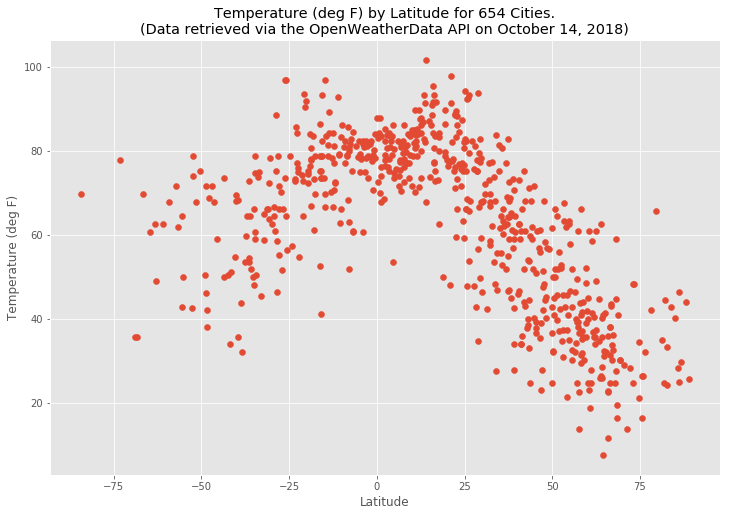

In [51]:
# Latitude vs Temperature
plt.scatter(city_df2["latitude"], city_df2["Temperature (F)"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (deg F)")
plt.title("Temperature (deg F) by Latitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/lat_temp.png")
plt.show()

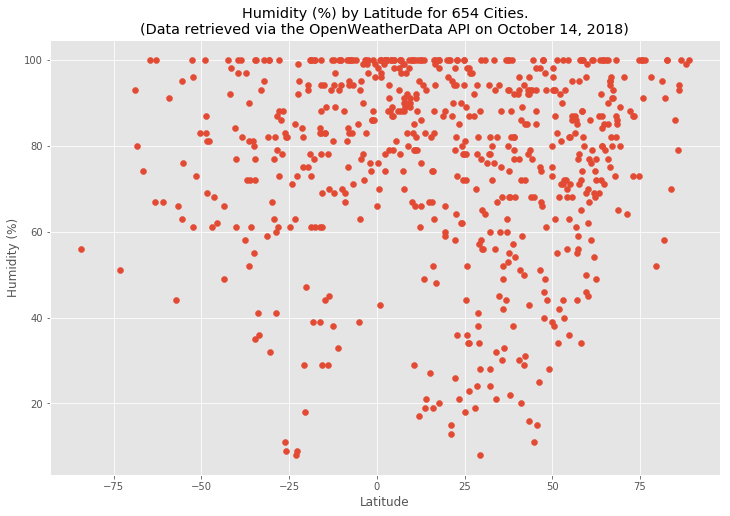

In [52]:
# Latitude vs Humidity
plt.scatter(city_df2["latitude"], city_df2["Humidity (%)"])
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Humidity (%) by Latitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/lat_hum.png")
plt.show()

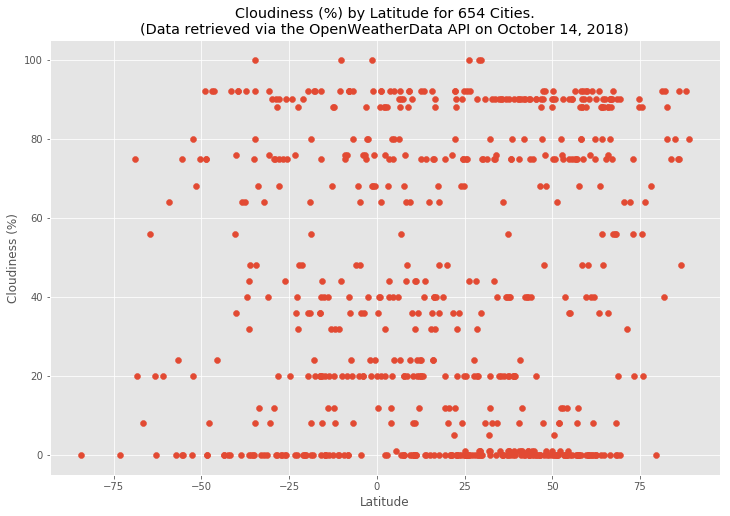

In [53]:
# Latitude vs Cloudiness
plt.scatter(city_df2["latitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Cloudiness (%) by Latitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/lat_cloud.png")
plt.show()

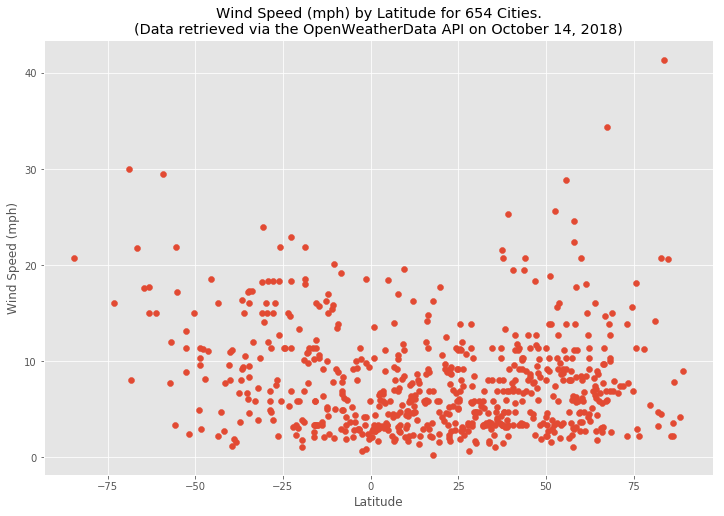

In [54]:
# Latitude vs Wind Speed
plt.scatter(city_df2["latitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) by Latitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/lat_wind.png")
plt.show()

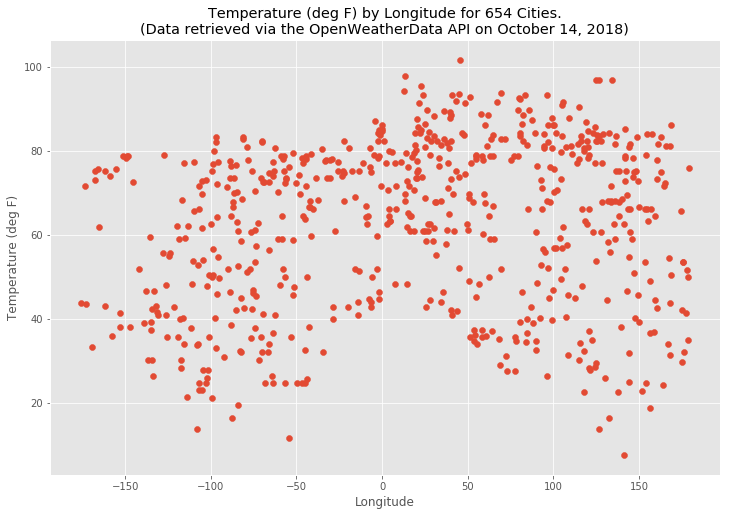

In [55]:
# Longitude vs Temperature
plt.scatter(city_df2["longitude"], city_df2["Temperature (F)"])
plt.xlabel("Longitude")
plt.ylabel("Temperature (deg F)")
plt.title("Temperature (deg F) by Longitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/long_temp.png")
plt.show()

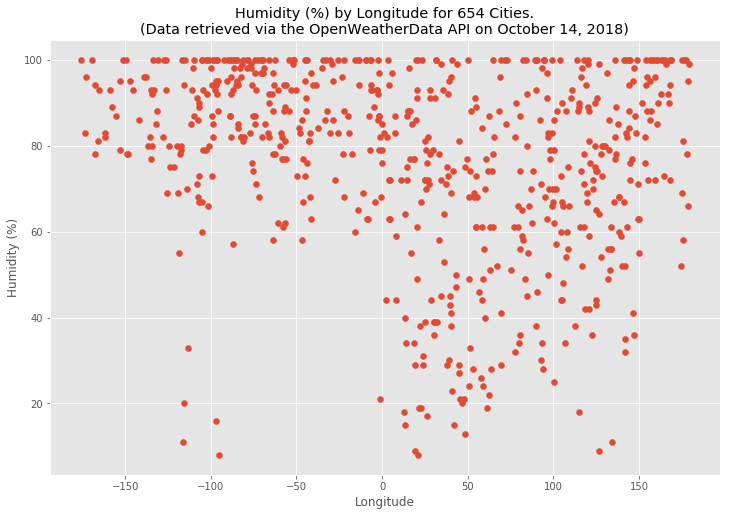

In [56]:
# Longitude vs Humidity
plt.scatter(city_df2["longitude"], city_df2["Humidity (%)"])
plt.xlabel("Longitude")
plt.ylabel("Humidity (%)")
plt.title("Humidity (%) by Longitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/long_hum.png")
plt.show()

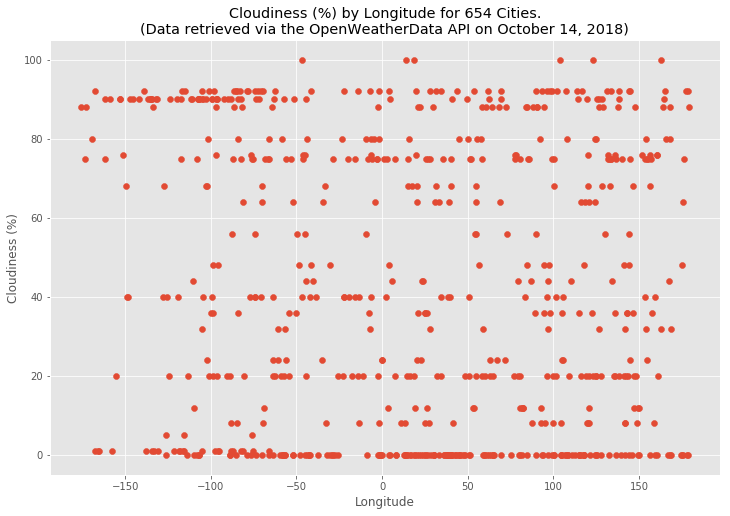

In [57]:
# Longitude vs Cloudiness
plt.scatter(city_df2["longitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Longitude")
plt.ylabel("Cloudiness (%)")
plt.title("Cloudiness (%) by Longitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/long_cloud.png")
plt.show()

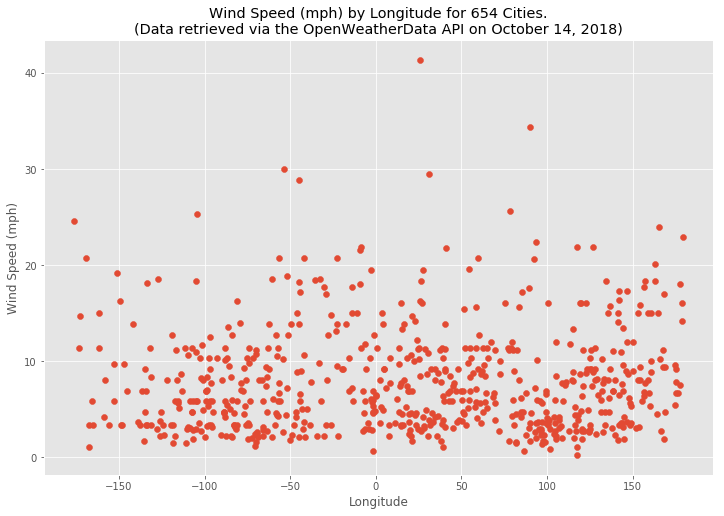

In [58]:
# Longitude vs Wind Speed
plt.scatter(city_df2["longitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Longitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) by Longitude for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/long_wind.png")
plt.show()

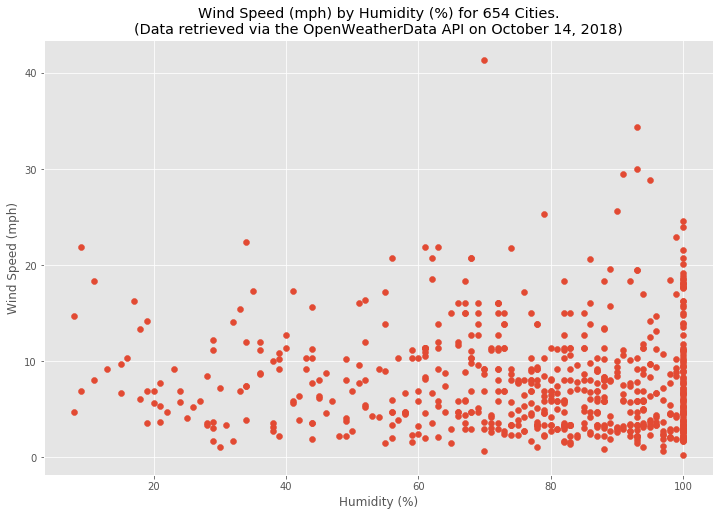

In [63]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Humidity (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) by Humidity (%) for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/hum_wind.png")
plt.show()

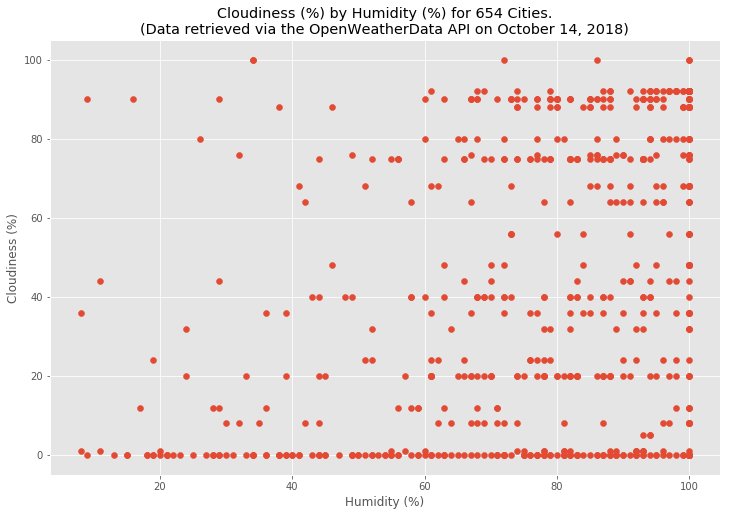

In [60]:
# Humidity vs Cloudiness
plt.scatter(city_df2["Humidity (%)"], city_df2["Cloudiness (%)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Cloudiness (%)")
plt.title("Cloudiness (%) by Humidity (%) for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/hum_cloud.png")
plt.show()

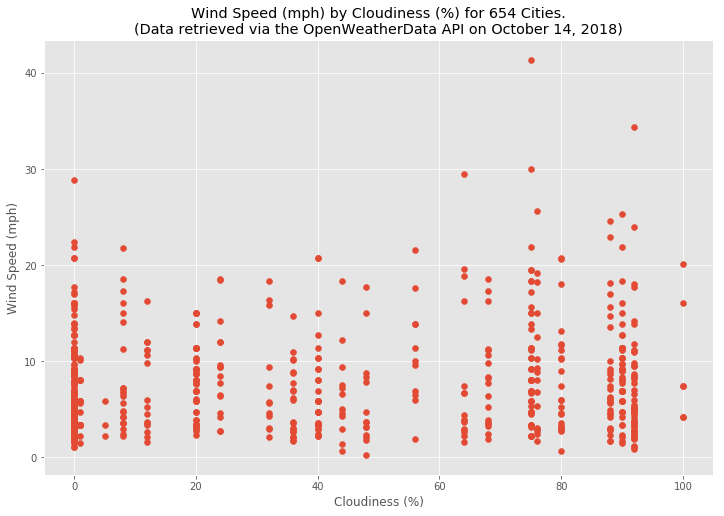

In [62]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Cloudiness (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Cloudiness (%)")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) by Cloudiness (%) for 654 Cities.\n(Data retrieved via the OpenWeatherData API on October 14, 2018)")

# Save image
plt.savefig("Images/cloud_wind.png")
plt.show()